In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix,
    get_deps_from_inverse_sig
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data by Passing in Edge List

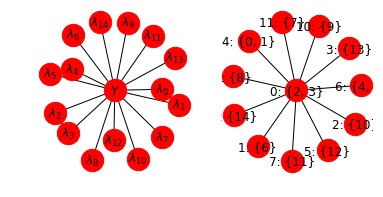

In [3]:
M = 15
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#Generate Data
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
mu = data.get_mu()

In [83]:
device = torch.device("cpu")

#Create input
sig_inv = np.linalg.pinv(sigma_O)
O_inv = torch.tensor(sig_inv, dtype=torch.float)
m = np.shape(O_inv)[0]

#Create output
#L has to be symmetric (L = zz^T)
z = torch.randn((m,1), device=device, dtype=torch.float, requires_grad=True)
#Sigma has to be sparse and symmetric
S = torch.randn((m,m), device=device, dtype=torch.float, requires_grad=True)

optimizer = torch.optim.SGD([z,S], lr=1e-2, momentum=0.9)
lam = 0.05
for t in range(1000):
    
    #make symmetric
    S = (S+S.t())/2.
    
    loss = torch.norm(O_inv - torch.mm(z,z.t()) - S) + (lam*torch.sum(torch.abs(S)))
    if t % 100 == 0:
        print (loss.item())
    
    #zero gradient, backward pass, update variables
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

28.42363166809082
23.052600860595703
23.01727867126465
23.017274856567383
23.017274856567383
23.017274856567383
23.017274856567383
23.017274856567383
23.017274856567383
23.017274856567383


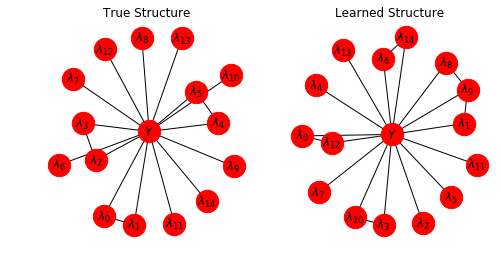

In [97]:
J_hat = S.detach().numpy()
deps_hat = get_deps_from_inverse_sig(np.abs(J_hat), thresh=1.5) 
deps = []
for i,j in deps_hat:
    if i < j:
        deps.append((i,j))
        
deps_graph_est = DependenciesGraph(M, deps)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()